In [1]:
import sys
sys.path.append('../NeuroDataResource')
sys.path.append('../Util')

import time
import pickle
import numpy as np
from CollmanSVM import CollmanSVM
from Util import delta_epsilon
from matplotlib import pyplot as plt
from NeuroDataResource import NeuroDataResource

# Overview
The Collman SVM pseudocode is given below:
```
clusters = MedianFilter(data)

for biomarker_channel in clusters:
    mu = mean(biomarker_channel)
    sigma = stdev(biomarker_channel)
    biomarker_channel = (biomarker_channel - mu)/sigma

svm = svm.fit(clusters, cluster_labels, kkt_violation=.04)
```

## Collman SVM Class
### Constructor
The constructor for CollmanSVM takes 2 parameters:
- resource: a NeuroDataResource containing the channels
    - GABA488
    - gephyrin594
    - GAD647
    - Synapsin647
    - GS594
    - VGluT1_647
    - annotation
    
- resolution:
    The number of nanometers per pixel edge

In [2]:
myToken = pickle.load(open('../NeuroDataResource/data/token.pkl', 'rb'))

bioMarkerDict = [{'name': 'PSD95_488', 'dtype':'uint8'},
                 {'name': 'GABA488', 'dtype':'uint8'},
                 {'name': 'gephyrin594', 'dtype':'uint8'},
                 {'name': 'GAD647', 'dtype':'uint8'},
                 {'name': 'Synapsin647', 'dtype':'uint8'},
                 {'name': 'GS594', 'dtype':'uint8'},
                 {'name': 'VGluT1_647', 'dtype':'uint8'},
                 {'name': 'annotation', 'dtype':'uint64'},
                ]

ndr = NeuroDataResource('api.boss.neurodata.io',
                        myToken,
                        'collman',
                        'collman15v2',
                        bioMarkerDict)

svm = CollmanSVM(ndr, 3.)

The constructor will throw an error if the resource does not have the correct channels:

In [3]:
for i in range(len(bioMarkerDict)):
    badDict = [elem for j, elem in enumerate(bioMarkerDict) if i != j]
    
    badndr = NeuroDataResource('api.boss.neurodata.io',
                            myToken,
                            'collman',
                            'collman15v2',
                            badDict)

    try:
        svm = CollmanSVM(badndr, 3.)
        print(bioMarkerDict[i]['name'], ' Error Not Raised!')
    except ValueError:
        print(bioMarkerDict[i]['name'], ' Error Raised Succesfully!')

PSD95_488  Error Raised Succesfully!
GABA488  Error Raised Succesfully!
gephyrin594  Error Raised Succesfully!
GAD647  Error Raised Succesfully!
Synapsin647  Error Raised Succesfully!
GS594  Error Raised Succesfully!
VGluT1_647  Error Raised Succesfully!
annotation  Error Raised Succesfully!


### Class Methods
The CollmanSVM class cotains methods:

1. masked_z_transform(mask, data): perform a z transform on a subset of the data
    - mask: np array of 1's and 0's of the same shape as data. Elements with a 1 will be included in z transform calculations
    - data: the data to z transform
    
2. make_svm_example(clusters, zChannels, clusterIdx): returns a [label, feature vector] pair for training an SVM
    - clusters: a labeled volume from median_filter
    - zChannels: z-transformed biomarkers from masked_z_transform
    - clusterIdx: the index of the cluster to label

3. train_on_volume(zRange, yRange, xRange): trains the SVM on the z transformed features in the range specified by the arguments

#### masked_z_transform
A couple fo simple validation examples:

In [4]:
synthetic = np.stack([[1, 1, 0, 0, 0],
                      [1, 1, 0, 0, 0],
                      [0, 0, 0, 0, 0],
                      [0, 0, 0, 2, 2],
                      [0, 0, 0, 2, 2]])

mask = np.stack([[1, 1, 0, 0, 0],
                 [1, 1, 0, 0, 0],
                 [0, 0, 0, 0, 0],
                 [0, 0, 0, 1, 1],
                 [0, 0, 0, 1, 1]])


In [5]:
z_volume = svm.masked_z_transform(mask, synthetic)

If the algorithm worked as planned, the output should have mean 0 and variance 1 when first multiplied with the mask

In [6]:
testMu = np.sum(np.multiply(mask, z_volume))/np.count_nonzero(mask)
print('Mean:', testMu)

Mean: 0.0


In [7]:
testVar = np.sum(np.multiply(mask, (z_volume)**2))/np.count_nonzero(mask)
print('Var:', testVar)

Var: 1.0


We can also assert that the output is what can be computed by hand

In [8]:
np.multiply(mask, z_volume) == np.stack([[-1, -1, 0, 0, 0],
                                         [-1, -1, 0, 0, 0],
                                         [0, 0, 0, 0, 0],
                                         [0, 0, 0, 1, 1],
                                         [0, 0, 0, 1, 1]])

array([[ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True]], dtype=bool)

Additionally, we can generate a series of random inputs and make sure that they have mean 0 and variance 1

In [9]:
for i in range(10):
    synthetic = np.random.random((100, 100))
    mask= np.array(np.random.random((100, 100)) < .5).astype(float)
    z_volume = svm.masked_z_transform(mask, synthetic)
    
    testMu = np.sum(np.multiply(mask, z_volume))/np.count_nonzero(mask)
    testVar = np.sum(np.multiply(mask, (z_volume)**2))/np.count_nonzero(mask)
   
    #NOTE delta_epsilon(a, b, c) returns true if floats a and b differ by at most c 
    if delta_epsilon(testMu, 0., 1e-6) and delta_epsilon(testVar, 1., 1e-6):
        print('Test ',i, ': Passed!')
    else:
        print('Test ',i, ': Failed!')
        
        

Test  0 : Passed!
Test  1 : Passed!
Test  2 : Passed!
Test  3 : Passed!
Test  4 : Passed!
Test  5 : Passed!
Test  6 : Passed!
Test  7 : Passed!
Test  8 : Passed!
Test  9 : Passed!


#### make_svm_example
Validation Unit Test

In [10]:
syntheticX = np.stack([[1, 1, 0, 0, 0],
                       [1, 1, 0, 0, 0],
                       [0, 0, 0, 0, 0],
                       [0, 0, 0, 2, 2],
                       [0, 0, 0, 2, 2]])

mask = np.array(syntheticX > 0).astype(int)

syntheticBiomarker1 = np.stack([[1, 1, 0, 0, 0],
                                [1, 1, 0, 0, 0],
                                [0, 0, 0, 0, 0],
                                [0, 0, 0, 0, 0],
                                [0, 0, 0, 0, 0]])

syntheticBiomarker2 = np.random.random((5, 5))

syntheticBiomarkers = np.stack([syntheticBiomarker1,
                                syntheticBiomarker2])

syntheticZ = [svm.masked_z_transform(mask, elem) for elem in syntheticBiomarkers]

labels = np.stack([[1, 1, 0, 0, 0],
                 [1, 1, 0, 0, 0],
                 [0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0]])

In [11]:
examples = [svm.make_svm_example(syntheticX, syntheticZ, labels, i) for i in range(1, np.max(syntheticX) + 1)]

If this function runs as expected, then it will produce:
[[True, [1.0, random]], [False, [-1.0,random]]]
Since cluster 1 is the only cluster that is labeled, and the first biomaker has z transform of mean 1 and stdev 1

In [12]:
print(examples)

[[True, [1.0, 0.36117775795562146]], [False, [-1.0, -0.36117775795562124]]]


A validation test of the function running on a subset of real Collman Data

In [13]:
testCollmanLabel = ndr.get_cutout('annotation', [11, 13], [1800, 2700], [2500,3600])
testCollmanPSD = svm._medianFilter.detect([11, 13], [1800, 2700], [2500,3600])
testCollmanMarker = ndr.get_cutout('Synapsin647', [11, 13], [1800, 2700], [2500,3600])

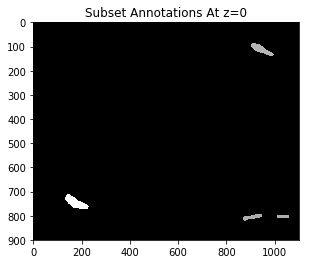

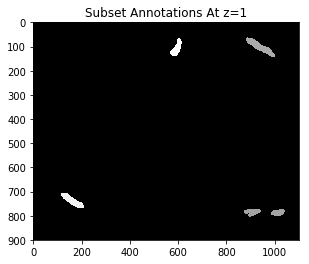

In [14]:
plt.figure()
for z in range(2):
    plt.title('Subset Annotations At z=' + str(z))
    plt.imshow(testCollmanLabel[z], cmap='gray')
    plt.show()

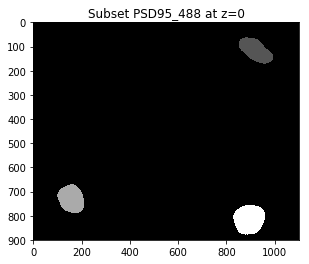

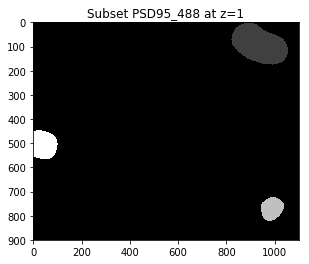

In [15]:
for z in range(2):
    plt.figure()
    plt.title('Subset PSD95_488 at z='+str(z))
    plt.imshow(testCollmanPSD[z], cmap='gray')
    plt.show()

Based on this distribution of labels and PSD Puncta, the make_svm_example should create 3 true and 1 false examples

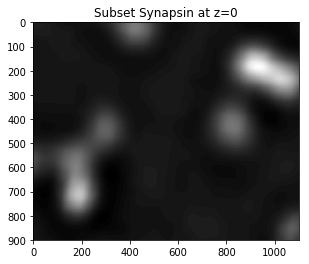

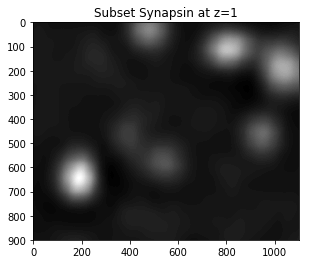

In [16]:
for z in range(2):
    plt.figure()
    plt.title('Subset Synapsin at z='+str(z))
    plt.imshow(testCollmanMarker[z], cmap='gray')
    plt.show()

In [17]:
zMarker = svm.masked_z_transform(testCollmanPSD, testCollmanMarker)

In [18]:
examples = [svm.make_svm_example(testCollmanPSD, [zMarker], testCollmanLabel, i)\
            for i in range(1, np.max(testCollmanPSD) + 1)]

In [ ]:
examples

[[True, [-0.29014704883193643]],
 [True, [-0.029918344799351734]],
 [True, [-0.80988035150648807]],
 [False, [-0.82873195288286772]]]

#### train_on_volume

In [ ]:
start = time.time()
svm.train_on_volume([1, 21], [1000, 2000], [1000, 2500])
end = time.time()

print('Training took: ', end - start, ' seconds!')

In [ ]:
predictions = svm.predict_on_volume([1, 21], [2000, 3000], [2500, 3500])

In [ ]:
medianFilter = svm._medianFilter.detect([1, 21], [2000, 3000], [2500,3500])

In [ ]:
gt = ndr.get_cutout('annotation',[1, 21], [2000, 3000], [2500, 3500])

In [ ]:

for i in range(19):
    plt.figure(figsize=(15, 35))
    plt.subplot(131)
    plt.title('SVM Predictions z='+str(i))
    plt.imshow(predictions[i], cmap='gray')
    
    plt.subplot(132)
    plt.title('Collman Basic (Median Filter) Predictions z=' + str(i))
    plt.imshow(medianFilter[i], cmap='gray')

    plt.subplot(133)
    plt.title('GT z=' + str(i))
    plt.imshow(gt[i], cmap='gray')
    plt.show()